In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import pandas_ta as ta

from model.patchtst  import PatchTST_SOTA
from model.quantile_head import QuantileRegressionHead
from utils.visualization import plot_predictions
from utils.data_loader import generate_data_from_df, invert_scale, invert_truth_scale, plot_unscaled_predictions

from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score
# from sklearn.preprocessing import LabelEncoder

from utils.labels import detect_head_and_shoulders, detect_double_bottom, label_patterns, create_windows
from utils.metrics import quantile_loss
from utils.classify_window import classify_window
# from utils.forecaster import forecaster

# from model.CNN.CNN1D import CNN1D_MultiChannel
# from model.CNN.CNN2D import CNN2D_MultiChannel

# from trainers.CNN1DTrainer import CNN1DTrainer, TimeSeries1DDataset
# from trainers.CNN2DTrainer import CNN2DTrainer, TimeSeries2DDataset

### Load data

In [6]:
filepath = "data"
filename = "NIFTY 50_minute_data.csv"
# filename = "NIFTY 50_daily_data.csv"

file = f"{filepath}/{filename}"

df_nifty50_full = pd.read_csv(file)
df_nifty50_full.shape

(932946, 6)

In [7]:
# extract all records since 01-01-2022

df_nifty50 = df_nifty50_full[df_nifty50_full['date'] > '2022-01-01 09:00:00']


df_nifty50.loc[:, "ema"] = ta.ema(df_nifty50['close'], length=15)
df_nifty50.loc[:, "rsi"] = ta.rsi(df_nifty50['close'], length=15)
df_nifty50.loc[:, "zscore"] = ta.zscore(df_nifty50['close'], length=15)

df_nifty50.dropna(inplace=True)
df_nifty50.reset_index(drop=True, inplace=True)
df_nifty50 = df_nifty50[['close','ema','rsi','zscore']]

/tmp/ipykernel_85419/3827485726.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nifty50.loc[:, "ema"] = ta.ema(df_nifty50['close'], length=15)
/tmp/ipykernel_85419/3827485726.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nifty50.loc[:, "rsi"] = ta.rsi(df_nifty50['close'], length=15)
/tmp/ipykernel_85419/3827485726.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

#### Note: Model performace improves when trained on < 100k records

### Transformer (PatchTST)

In [40]:
def directional_accuracy(pred: torch.Tensor, true: torch.Tensor) -> float:
    """
    Calculate Directional Accuracy between predictions and ground truth.
    """
    pred = pred[:, :, 1]  # Taking 0.5 quantile (median prediction)
    pred_change = pred[:, 1:] - pred[:, :-1]
    true_change = true[:, 1:] - true[:, :-1]
    correct = (torch.sign(pred_change) == torch.sign(true_change)).float()
    da = correct.mean().item()
    return da

In [41]:
feature_cols = ['close','ema','rsi','zscore']
checkpoint_path = "models_results/checkpoints/patch_tft_best_model.pt"

X, y, scaler = generate_data_from_df(df_nifty50, feature_cols, input_len=50, pred_len=10)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

seq_len, pred_len = 60, 10
quantiles = [0.1, 0.5, 0.9]

In [42]:
# Training Loop
epochs = 10

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

# Model, optimizer, loss
model = PatchTST_SOTA(input_len=seq_len, pred_len=pred_len, num_features=4)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train_losses = []
val_losses = []
val_accuracies = []
best_val_loss = float("inf")

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        output = model(batch_x)
        loss = quantile_loss(output, batch_y, quantiles)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    with torch.no_grad():
        for val_x, val_y in val_loader:
            val_output = model(val_x)
            loss = quantile_loss(val_output, val_y, quantiles)
            val_loss += loss.item()

            # Calculate directional accuracy
            da = directional_accuracy(val_output, val_y)
            val_acc += da

    avg_val_loss = val_loss / len(val_loader)
    avg_val_acc = val_acc / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_acc)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Directional Acc: {avg_val_acc:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), checkpoint_path)
        print(f"✅ Saved new best model at epoch {epoch+1} with Val Loss: {avg_val_loss:.4f}")

Epoch 1/10 | Train Loss: 0.0095 | Val Loss: 0.0038 | Val Directional Acc: 0.4975
✅ Saved new best model at epoch 1 with Val Loss: 0.0038
Epoch 2/10 | Train Loss: 0.0038 | Val Loss: 0.0036 | Val Directional Acc: 0.4974
✅ Saved new best model at epoch 2 with Val Loss: 0.0036
Epoch 3/10 | Train Loss: 0.0030 | Val Loss: 0.0035 | Val Directional Acc: 0.4971
✅ Saved new best model at epoch 3 with Val Loss: 0.0035
Epoch 4/10 | Train Loss: 0.0027 | Val Loss: 0.0021 | Val Directional Acc: 0.4977
✅ Saved new best model at epoch 4 with Val Loss: 0.0021
Epoch 5/10 | Train Loss: 0.0025 | Val Loss: 0.0025 | Val Directional Acc: 0.4979
Epoch 6/10 | Train Loss: 0.0024 | Val Loss: 0.0018 | Val Directional Acc: 0.4984
✅ Saved new best model at epoch 6 with Val Loss: 0.0018
Epoch 7/10 | Train Loss: 0.0023 | Val Loss: 0.0031 | Val Directional Acc: 0.4983
Epoch 8/10 | Train Loss: 0.0022 | Val Loss: 0.0021 | Val Directional Acc: 0.4981
Epoch 9/10 | Train Loss: 0.0021 | Val Loss: 0.0026 | Val Directional Acc

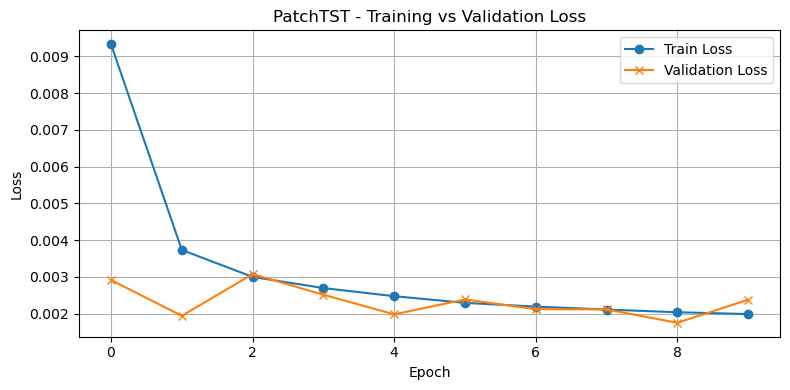

In [37]:
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label="Train Loss", marker='o')
plt.plot(val_losses, label="Validation Loss", marker='x')
plt.title("PatchTST - Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [9]:

def load_model(checkpoint_path, input_len, pred_len, num_features):
    model = PatchTST_SOTA(input_len=input_len, pred_len=pred_len, num_features=num_features)
    model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device('cpu')))
    model.eval()
    return model

def run_inference(model, test_loader, quantiles):
    model.eval()
    all_preds = []
    all_truth = []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            preds = model(x_batch)
            all_preds.append(preds)
            all_truth.append(y_batch)
    preds_tensor = torch.cat(all_preds, dim=0)
    truth_tensor = torch.cat(all_truth, dim=0)
    return preds_tensor, truth_tensor

torch.Size([57582, 10, 3])


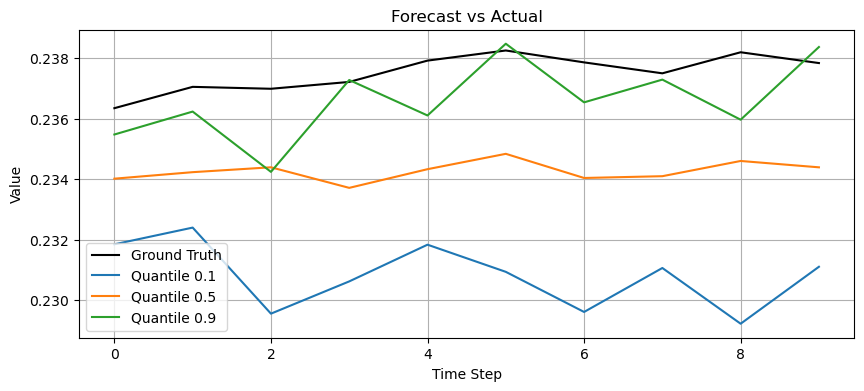

In [8]:
# from utils.data_loader import load_series_from_csv

# Parameters
batch_size = 1

valdataset = TensorDataset(X_val, y_val)
test_loader = DataLoader(valdataset, batch_size=32, shuffle=True)

# Load model
model = load_model(checkpoint_path, seq_len, pred_len, num_features=4)

# Run inference
preds, truth = run_inference(model, test_loader, quantiles)

print(preds.shape)

# Plot result for first sample
plot_predictions(preds, truth, quantiles, index=0)


In [9]:
unscaled_preds = invert_scale(preds, scaler, feature_index=0, num_features=4) 

In [10]:
unscaled_truth = invert_truth_scale(truth, scaler, feature_index=0, num_features=4)

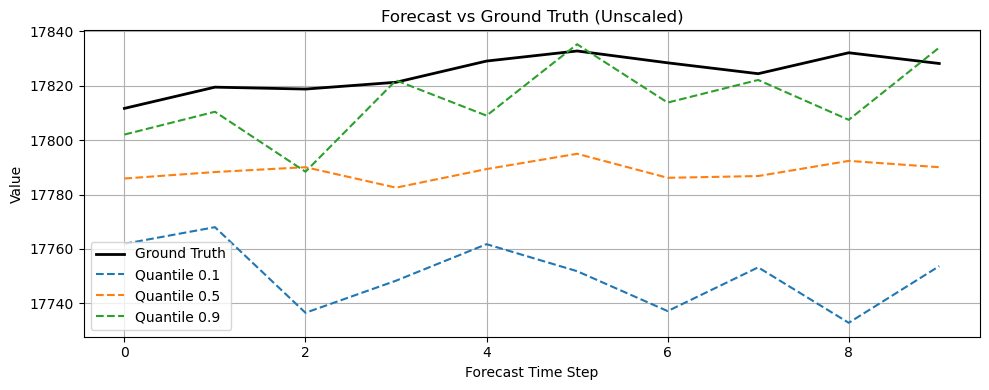

In [11]:
plot_unscaled_predictions(unscaled_preds, unscaled_truth, quantiles, index=0)

### Market Simulation

In [10]:
from MarketSimulator import * 

In [11]:
WINDOW_SIZE = 10
PATTERN_LABELS = ['head_and_shoulders', 'double_bottom', 'ascending_triangle', 'none']

#### Data preparation 

In [12]:
def extract_windows(df, seq_len, step_size):
    windows = []
    for start in range(0, len(df) - seq_len + 1, step_size):
        end = start + seq_len
        window = df.iloc[start:end].copy()
        windows.append(window)
    return windows

In [13]:
num_days = 10
trading_hrs = 6.5
simulation_data_size = int(60 * trading_hrs * num_days) # minutes * hrs * days 
window_seq_length = 60
step_size = WINDOW_SIZE

# Start at index 0 and then slide the window of size(WINDOW_SIZE) by step_size steps
simulation_windows = extract_windows(df_nifty50[-simulation_data_size:], window_seq_length, step_size)


#### Run forecasts

In [14]:
def run_model_prediction(model, scaler, raw_window, feature_cols, input_len,feature_index=0, num_features=4):
    """
    - preds: torch.Tensor of shape (1, pred_len, num_quantiles)
    """
    # Select and normalize
    data = raw_window[feature_cols].values
    data = scaler.transform(data)

    assert data.shape[0] == input_len, f"Expected window length {input_len}, got {data.shape[0]}"

    # Prepare tensor
    input_tensor = torch.tensor(data, dtype=torch.float32).unsqueeze(0)  # (1, input_len, num_features)

    # Predict
    forecast = model.predict(input_tensor)

    forecast_np = forecast.detach().cpu().numpy().squeeze(0)  # (pred_len, num_quantiles)

    # Unscale
    pred_len, num_quantiles = forecast_np.shape
    dummy = np.zeros((pred_len * num_quantiles, num_features))
    dummy[:, feature_index] = forecast_np.reshape(-1)
    unscaled = scaler.inverse_transform(dummy)[:, feature_index]
    forecast_unscaled = unscaled.reshape(pred_len, num_quantiles)
    
    return forecast_unscaled

In [15]:
model = load_model(checkpoint_path, seq_len, pred_len, num_features=4)


In [16]:
def reshape_forecast_for_cnn(forecast_tensor):
    """
    Input: forecast_tensor of shape (1, T, Q) or (T, Q)
    Output: reshaped tensor of shape (T, 4) for CNN
    """
    if isinstance(forecast_tensor, np.ndarray):
        forecast_np = forecast_tensor
    else:
        forecast_np = forecast_tensor.detach().cpu().numpy()

    if forecast_np.ndim == 3:
        forecast_np = forecast_np.squeeze(0)  # (T, Q)

    # Add 4th channel (mean of quantiles)
    avg_col = np.mean(forecast_np, axis=-1, keepdims=True)
    cnn_input = np.concatenate([forecast_np, avg_col], axis=-1)  # (T, 4)

    return torch.tensor(cnn_input, dtype=torch.float32)  # (T, 4)

In [22]:
# Prepare the simulation data
# This is a list of pairs of input sequence (60 timesteps) - that goes as input to the transoformer
# and the classification label for the input sequence

simulation_data = []

for fcast in simulation_windows:

    classified_forecast = dict()
    
    forecast = run_model_prediction(model, scaler, fcast,feature_cols, window_seq_length)
    classified_forecast['window'] = fcast['close']
    classified_forecast['forecast'] = forecast
    classified_forecast['label'] = classify_window(reshape_forecast_for_cnn(forecast), model_type='2d', model_path="models_results/checkpoints/CNN2D_MULTICHANNEL.pt", PATTERN_LABELS=PATTERN_LABELS)
    simulation_data.append(classified_forecast)
    

In [23]:
len(simulation_data)

385

In [34]:
trader = Trader()

# have to use a very high price tolerance as the forecast is way off the actual close price
simulator = MarketSimulator(processed_data=simulation_data, initial_budget=100000, price_tolerance=2700)

trade_log = simulator.simulate()

In [35]:
trade_log

[(0, 'buy', 20259.6971145913, 79740.3028854087),
 (0, 'sell', 20384.54108187407, 100124.84396728277),
 (1, 'buy', 20254.51817829907, 79870.3257889837),
 (1, 'sell', 20379.50183123201, 100249.82762021571),
 (2, 'buy', 20260.38002221435, 79989.44759800137),
 (2, 'sell', 20383.496576645968, 100372.94417464733),
 (3, 'buy', 20257.342602331937, 80115.6015723154),
 (3, 'sell', 20382.489717195927, 100498.09128951133),
 (4, 'buy', 20233.18590095788, 80264.90538855345),
 (4, 'sell', 20357.627652822433, 100622.5330413759),
 (5, 'buy', 20242.237068772316, 80380.29597260358),
 (5, 'sell', 20365.000941704213, 100745.2969143078),
 (6, 'buy', 20248.779838953913, 80496.51707535388),
 (6, 'sell', 20371.95517363548, 100868.47224898936),
 (7, 'buy', 20243.273648573457, 80625.1986004159),
 (7, 'sell', 20368.334904645384, 100993.53350506128),
 (8, 'buy', 20249.503034164012, 80744.03047089727),
 (8, 'sell', 20373.654517266154, 101117.68498816343),
 (9, 'buy', 20256.15378828794, 80861.53119987549),
 (9, 'sel

In [44]:
trade_log_df = pd.DataFrame(trade_log, columns=['ID', 'Action', 'Price', 'Amount'])
trade_log_df = trade_log_df[trade_log_df[]


In [ ]:
# Save as CSV
df.to_csv('transaction_data.csv', index=False)